# Comparative Attention Analysis of Generative Language Models 
#### Medical vs. Legal Question Answering

**Field**: 
    Natural Language Processing (NLP)

**Rationale:**
    This project investigates interpretability in generative language models applied to question answering (QA) in medical and legal domains. Given its emphasis on transformer-based models and attention mechanisms, it directly aligns with the course focus on NLP. The motivation stems from understanding how models process and differentiate domain-specific information, especially in high-stakes areas like medicine and law.



**Imports**

In [1]:
import torch
import pandas as pd
from datasets import load_dataset
from transformers import T5TokenizerFast
from transformers import pipeline
import re
import tqdm

/opt/homebrew/Caskroom/miniforge/base/envs/IE7374/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## **Dataset Loading and Sampling**

**Dataset Description**
**Medical Domain:**
 - Dataset: MedMCQA (USMLE-style questions)
 - Source: [ MedMCQA](https://medmcqa.github.io)/ Hugging Face 
 - Size: ~180,000 multiple-choice clinical questions
 - Format: JSON (text-based)
 - Characteristics: Contains complex, high-level clinical scenarios requiring domain-specific knowledge.

 **Legal Domain:**
 - Dataset: dzunggg/legal-qa-v1
 - Source: Hugging Face
 - Size: ~3,700 rows
 - Format: Text-based QA pairs
 - Characteristics: Involves formal language, legal citations, and logical reasoning based on statutes or precedents.

**Notes**
Change N to get more sample data use 50 during development 

In [2]:

# Load full splits
med_full   = load_dataset("medmcqa", split="train")
legal_full = load_dataset("dzunggg/legal-qa-v1", split="train")

# Reproducible sampling
N = 50
SEED = 42
med_sample   = med_full.shuffle(seed=SEED).select(range(N))
legal_sample = legal_full.shuffle(seed=SEED).select(range(N))

# Convert to DataFrames for easy preview/manipulation
df_med   = pd.DataFrame(med_sample)
df_legal = pd.DataFrame(legal_sample)

print(f"Sampled {len(df_med)} medical and {len(df_legal)} legal questions.")

# Preview the first few rows
display(df_med.head())
display(df_legal.head())


Generating train split: 100%|██████████| 3742/3742 [00:00<00:00, 51143.38 examples/s]

Sampled 50 medical and 50 legal questions.


,id,question,opa,opb,opc,opd,cop,choice_type,exp,subject_name,topic_name
0,c69ce981-e254-4707-b87a-cb493e8a948e,OPV can be used if vaccine l monitor is showing?,Colour of outer circle is same as inner square,Colour of outer circle is darker than inner sq...,Colour of outer circle is lighter than inner s...,None of the above,1,multi,"Ans. is 'b' i.e., Colour of outer circle is da...",Social & Preventive Medicine,None
1,4bf5d147-3860-4dcf-ac71-9f9b0a87e583,Average gain of height in first year ?,25 cms,50 cms,75 cms,100 cms,0,single,O.P. Ghai 9th Edition - page 13,Anatomy,General anatomy
2,a524efbb-8a52-4298-9f4f-40790d95c8b9,Investigation of choice to diagnose congenital...,USG,HSG,MRI,CT,2,single,MRI is the investigation of choice to diagnose...,Gynaecology & Obstetrics,None
3,8d5a6669-3645-4275-a1da-89ee456bf3fd,Pain is appreciated when the small bowel is,Burned,crushed,Cut,distended,3,multi,The gut is insensitive to common painful stimu...,Surgery,None
4,e778cda1-38c5-4583-bf9d-02979ff48c67,The main advantage of RPD over FPD in replacin...,Cross arch stabilization,Aesthetics,Less expensive,Comfort to the patient,0,single,None,Dental,None


,question,answer
0,Q: Can I patent a game that has open domain IP...,A:Your situation requires more facts and to de...
1,Q: I did work on a commercial property. Owner ...,A:You will need a MT attorney on this. Your ma...
2,Q: My catalytic converter was stolen from my c...,"A:In your case, the first aspect to consider i..."
3,Q: Are there any lawyers in Florida that can h...,"A:Sure, there are some lawyers handling genera..."
4,Q: Can livestock be raised and sold to fund a ...,A:The legality of raising and selling livestoc...


## **Text Cleaning**

- Removed HTML artifacts
- Remove Markdown artifacts
- Remove Q. A. in the one of the data set before question and Answer data
- Remove multiple spaces to single
- create new column clean_questions 

In [3]:
# cleaning function
def clean_text(text):
    text = text.lower().strip()
    # remove any HTML/Markdown artifacts if present
    text = re.sub(r"<[^>]+>", " ", text)
    text = re.sub(r"!\[.*?\]\(.*?\)", " ", text)
    text = re.sub(r"\[.*?\]\(.*?\)", " ", text)
    text = re.sub(r"\s+", " ", text)
    #remove prefix Q: A: in some datasets
    text = re.sub(r'^[QqAa]:\s*', '', text).strip()
    return text

# Apply to a small sample
df_med["clean_question"] = df_med["question"].apply(clean_text)
df_legal["clean_question"] = df_legal["question"].apply(clean_text)

display(df_med.head())
display(df_legal.head())


,id,question,opa,opb,opc,opd,cop,choice_type,exp,subject_name,topic_name,clean_question
0,c69ce981-e254-4707-b87a-cb493e8a948e,OPV can be used if vaccine l monitor is showing?,Colour of outer circle is same as inner square,Colour of outer circle is darker than inner sq...,Colour of outer circle is lighter than inner s...,None of the above,1,multi,"Ans. is 'b' i.e., Colour of outer circle is da...",Social & Preventive Medicine,None,opv can be used if vaccine l monitor is showing?
1,4bf5d147-3860-4dcf-ac71-9f9b0a87e583,Average gain of height in first year ?,25 cms,50 cms,75 cms,100 cms,0,single,O.P. Ghai 9th Edition - page 13,Anatomy,General anatomy,average gain of height in first year ?
2,a524efbb-8a52-4298-9f4f-40790d95c8b9,Investigation of choice to diagnose congenital...,USG,HSG,MRI,CT,2,single,MRI is the investigation of choice to diagnose...,Gynaecology & Obstetrics,None,investigation of choice to diagnose congenital...
3,8d5a6669-3645-4275-a1da-89ee456bf3fd,Pain is appreciated when the small bowel is,Burned,crushed,Cut,distended,3,multi,The gut is insensitive to common painful stimu...,Surgery,None,pain is appreciated when the small bowel is
4,e778cda1-38c5-4583-bf9d-02979ff48c67,The main advantage of RPD over FPD in replacin...,Cross arch stabilization,Aesthetics,Less expensive,Comfort to the patient,0,single,None,Dental,None,the main advantage of rpd over fpd in replacin...


,question,answer,clean_question
0,Q: Can I patent a game that has open domain IP...,A:Your situation requires more facts and to de...,can i patent a game that has open domain ips s...
1,Q: I did work on a commercial property. Owner ...,A:You will need a MT attorney on this. Your ma...,i did work on a commercial property. owner is ...
2,Q: My catalytic converter was stolen from my c...,"A:In your case, the first aspect to consider i...",my catalytic converter was stolen from my car ...
3,Q: Are there any lawyers in Florida that can h...,"A:Sure, there are some lawyers handling genera...",are there any lawyers in florida that can help...
4,Q: Can livestock be raised and sold to fund a ...,A:The legality of raising and selling livestoc...,can livestock be raised and sold to fund a loc...


## **Subword-to-Word Mapping over DataFrame**

Create tokens and sub2word_map columns using T5Tokenizer

In [4]:

# Instantiate tokenizer 
tokenizer = T5TokenizerFast.from_pretrained("t5-small")

# Define the mapping function 
# Offset-based mapping function only
def map_subwords_to_words_offsets(text: str, tokenizer):
    enc = tokenizer(
        text,
        return_offsets_mapping=True,
        add_special_tokens=False
    )
    toks    = tokenizer.convert_ids_to_tokens(enc["input_ids"])
    offsets = enc["offset_mapping"]

    words = text.split()
    # Build char→word index map
    char2word = []
    for idx, w in enumerate(words):
        char2word += [idx] * len(w) + [None]
    char2word = char2word[: len(text)]

    clean_toks, clean_map = [], []
    for tok, (start, end) in zip(toks, offsets):
        # Drop standalone whitespace marker
        if tok == "▁":
            continue
        # Normalize token by stripping leading ▁
        clean_tok = tok.lstrip("▁")
        if not clean_tok:
            continue
        # Map via offset
        if start >= len(char2word):
            continue
        widx = char2word[start]
        if widx is None:
            continue
        clean_toks.append(clean_tok)
        clean_map.append(words[widx])

    return clean_toks, clean_map


# Apply the mapping function to produce a Series of (tokens, mapping) tuples
mapped_med = df_med["clean_question"].apply(lambda t: map_subwords_to_words_offsets(t, tokenizer))
mapped_leg = df_legal["clean_question"].apply(lambda t: map_subwords_to_words_offsets(t, tokenizer))

# Split the tuples into two separate columns
df_med["tokens"]        = mapped_med.apply(lambda x: x[0])
df_med["sub2word_map"]  = mapped_med.apply(lambda x: x[1])

df_legal["tokens"]       = mapped_leg.apply(lambda x: x[0])
df_legal["sub2word_map"] = mapped_leg.apply(lambda x: x[1])

# Preview
print("Medical example:")
print("  Q:", df_med.loc[0, "clean_question"])
print("  tokens:", df_med.loc[0, "tokens"][:10])
print("  mapping:", df_med.loc[0, "sub2word_map"][:10])

print("\nLegal example:")
print("  Q:", df_legal.loc[0, "clean_question"])
print("  tokens:", df_legal.loc[0, "tokens"][:10])
print("  mapping:", df_legal.loc[0, "sub2word_map"][:10])


Medical example:
  Q: opv can be used if vaccine l monitor is showing?
  tokens: ['o', 'p', 'v', 'can', 'be', 'used', 'if', 'vaccine', 'l', 'monitor']
  mapping: ['opv', 'opv', 'opv', 'can', 'be', 'used', 'if', 'vaccine', 'l', 'monitor']

Legal example:
  Q: can i patent a game that has open domain ips such as santa clause? i’m making a game where santa is the main villain. i am making the story unique and bringing my own twist on christmas and a dark tale of horror with my own unique characters and ideas.
  tokens: ['can', 'i', 'patent', 'a', 'game', 'that', 'has', 'open', 'domain', 'ips']
  mapping: ['can', 'i', 'patent', 'a', 'game', 'that', 'has', 'open', 'domain', 'ips']


## **Auto Tags**

- create Tags based on zero-shot classifer using model distilbart
- Adds auto_tags and tag_scores to the dataset

In [5]:
# Define candidate topic labels
candidate_labels = [
    # Medical
    "diagnosis","treatment","symptom","vaccine","drug",
    "infection","prevention","side effects","pathology",
    # Legal
    "contract","tort","criminal law","intellectual property",
    "procedure","evidence","liability","regulation","rights"
]
#model_name="facebook/bart-large-mnli",
# Use a lighter NLI model for speed
model_name = "valhalla/distilbart-mnli-12-1"

# Initialize the zero-shot classifier
classifier = pipeline(
    "zero-shot-classification",
    model=model_name,
    device=0 if torch.cuda.is_available() else -1 ,
    batch_size=16,
)

''' 
# Helper to fetch top-k labels
def get_top_labels(text, k=3):
    result = classifier(text, candidate_labels, multi_label=False)
    return result["labels"][:k]

# Apply to clean questions
df_med["auto_tags"]   = df_med["clean_question"].apply(lambda q: get_top_labels(q, k=3))
df_legal["auto_tags"] = df_legal["clean_question"].apply(lambda q: get_top_labels(q, k=3))
'''
def batch_tag(df, text_col="clean_question", k=3):
    texts = df[text_col].tolist()
    results = classifier(texts, candidate_labels, multi_label=True)
    df["auto_tags"] = [res["labels"][:k] for res in results]

def batch_tag_with_thresh(df, text_col="clean_question", threshold=0.3):
    texts = df[text_col].tolist()
    results = classifier(texts, candidate_labels)
    all_tags, all_scores = [], []
    for res in results:
        labels = res["labels"]
        scores = res["scores"]
        # keep any label whose score ≥ threshold
        kept = [lab for lab, sc in zip(labels, scores) if sc >= threshold]
        all_tags.append(kept)
        all_scores.append([sc for sc in scores if sc >= threshold])
    df["auto_tags"]   = all_tags
    df["tag_scores"] = all_scores


batch_tag(df_med)
batch_tag(df_legal)
#batch_tag_with_thresh(df_med)
#batch_tag_with_thresh(df_legal)

# Preview
pd.set_option("display.max_colwidth", 60)
print("── Medical Examples (auto_tags) ──────────────────")
print(df_med[["clean_question","auto_tags"]].head(5).to_string(index=False))
print("\n── Legal Examples (auto_tags) ───────────────────")
print(df_legal[["clean_question","auto_tags"]].head(5).to_string(index=False))

Device set to use cpu


── Medical Examples (auto_tags) ──────────────────
                                                         clean_question                        auto_tags
                       opv can be used if vaccine l monitor is showing?     [vaccine, symptom, evidence]
                                 average gain of height in first year ?   [evidence, symptom, procedure]
           investigation of choice to diagnose congenital malformations [procedure, evidence, pathology]
                            pain is appreciated when the small bowel is  [symptom, side effects, rights]
the main advantage of rpd over fpd in replacing bilateral lost teeth is [evidence, procedure, treatment]

── Legal Examples (auto_tags) ───────────────────
                                                                                                                                                                                                                                                                            

## **Merge DataSets**

- Merge two domain datasets with column Domain values Medical and Legal

In [6]:
# Merge into Unified QA DataFrame & Compute Tag Salience 


# Tag each source
df_med["Domain"]   = "Medical"
df_legal["Domain"] = "Legal"

# Concatenate into one QA table
qa_pairs = pd.concat([df_med, df_legal], ignore_index=True)

# 3) Compute TagSalience: what fraction of the model’s own auto_tags
#    actually appear in the token list?
def compute_tag_salience(tokens, tags):
    if not tags:
        return 0.0
    token_set = set(t.lower() for t in tokens)
    hits = sum(1 for tag in tags if tag.lower() in token_set)
    return hits / len(tags)

qa_pairs["TagSalience"] = qa_pairs.apply(
    lambda row: compute_tag_salience(row["tokens"], row["auto_tags"]), axis=1
)

# Quick preview
pd.set_option("display.max_colwidth", 360)
preview_cols = ["Domain", "clean_question", "auto_tags", "TagSalience"]
display(qa_pairs[preview_cols].head(10))


,Domain,clean_question,auto_tags,TagSalience
0,Medical,opv can be used if vaccine l monitor is showing?,"[vaccine, symptom, evidence]",0.333333
1,Medical,average gain of height in first year ?,"[evidence, symptom, procedure]",0.000000
2,Medical,investigation of choice to diagnose congenital malformations,"[procedure, evidence, pathology]",0.000000
3,Medical,pain is appreciated when the small bowel is,"[symptom, side effects, rights]",0.000000
4,Medical,the main advantage of rpd over fpd in replacing bilateral lost teeth is,"[evidence, procedure, treatment]",0.000000
5,Medical,which is seen in chediak higashi syndrome,"[symptom, evidence, pathology]",0.000000
6,Medical,the stye is other name of,"[symptom, side effects, infection]",0.000000
7,Medical,metal fume fever is common in chronic poisoning with -,"[infection, side effects, symptom]",0.000000
8,Medical,ionophores have following action except:,"[infection, procedure, side effects]",0.000000
9,Medical,which of the following part of psychosexual theory operates on the pleasure principle and attempts to obtain pleasure:,"[evidence, procedure, treatment]",0.000000


## **Tag summary**

In [8]:
summary = qa_pairs.groupby('Domain')['TagSalience'].agg(
    total_questions='count',
    questions_with_tags=lambda x: (x > 0).sum(),
    percent_with_tags=lambda x: (x.gt(0).mean() * 100)
).reset_index()
print(summary.to_markdown(index=False))

| Domain   |   total_questions |   questions_with_tags |   percent_with_tags |
|:---------|------------------:|----------------------:|--------------------:|
| Legal    |                50 |                     9 |                  18 |
| Medical  |                50 |                     5 |                  10 |


## **Visualize TagSalience Distribution**

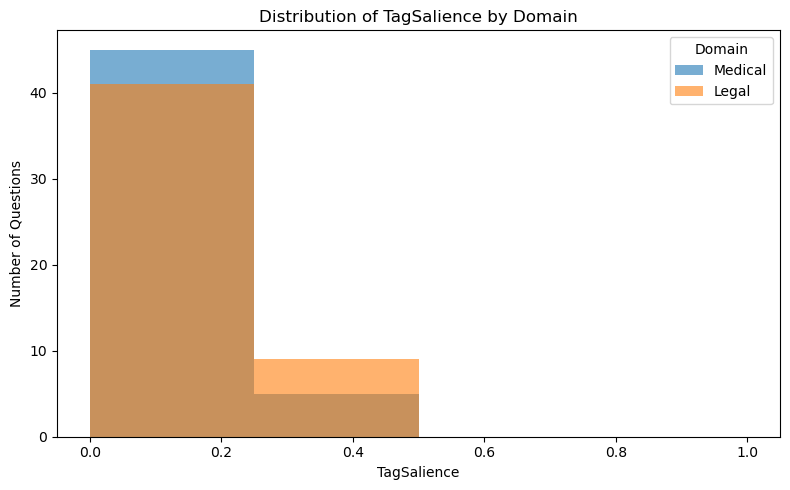

In [10]:
# Cell Y: Visualize TagSalience distributions

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))

# Plot histogram for each domain
bins = [0, 0.25, 0.5, 0.75, 1.0]
for domain in qa_pairs['Domain'].unique():
    subset = qa_pairs[qa_pairs['Domain'] == domain]
    plt.hist(subset['TagSalience'], bins=bins, alpha=0.6, label=domain)

plt.xlabel("TagSalience")
plt.ylabel("Number of Questions")
plt.title("Distribution of TagSalience by Domain")
plt.legend(title="Domain")
plt.tight_layout()
plt.show()


## **Keyword**
- using  TF‐IDF to extract keywords
- Add keywords for each question so that it can be grouped later

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

# 1) Fit TF‐IDF on all clean questions
vectorizer = TfidfVectorizer(
    stop_words="english",
    ngram_range=(1,2),
    smooth_idf=True
)
tfidf = vectorizer.fit_transform(qa_pairs["clean_question"])
feature_names = vectorizer.get_feature_names_out()

# 2) Extract top‐K keywords per question
def extract_keywords(row_vec, feature_names, top_k=5):
    # pair (feature, score) and take top_k
    scores = list(zip(feature_names, row_vec.toarray().flatten()))
    top = sorted(scores, key=lambda x: x[1], reverse=True)[:top_k]
    return [term for term, score in top if score > 0]

qa_pairs["keywords"] = [
    extract_keywords(tfidf[i], feature_names, top_k=5)
    for i in range(tfidf.shape[0])
]


# Quick preview
pd.set_option("display.max_colwidth", 360)
preview_cols = ["Domain", "clean_question", "keywords"]


print(qa_pairs[preview_cols].head(10).to_markdown(index=False))

| Domain   | clean_question                                                                                                         | keywords                                                                                         |
|:---------|:-----------------------------------------------------------------------------------------------------------------------|:-------------------------------------------------------------------------------------------------|
| Medical  | opv can be used if vaccine l monitor is showing?                                                                       | ['monitor', 'monitor showing', 'opv', 'opv used', 'used vaccine']                                |
| Medical  | average gain of height in first year ?                                                                                 | ['average', 'average gain', 'gain height', 'height', 'height year']                              |
| Medical  | investigation of choice to diagnose congenital malforma

## **KeywordSalience**

In [12]:
# assuming qa_pairs already has a 'keywords' column
def compute_kw_salience(tokens, keywords):
    if not keywords:
        return 0.0
    token_set = set(tokens)
    hits = sum(1 for kw in keywords if kw in token_set)
    return hits / len(keywords)

qa_pairs["KeywordSalience"] = qa_pairs.apply(
    lambda r: compute_kw_salience(r["tokens"], r["keywords"]), axis=1
)


In [13]:
summary = qa_pairs.groupby('Domain')['KeywordSalience'].agg(
    total_questions='count',
    questions_with_Keyword=lambda x: (x > 0).sum(),
    percent_with_Keyword=lambda x: (x.gt(0).mean() * 100)
).reset_index()
print(summary.to_markdown(index=False))

| Domain   |   total_questions |   questions_with_Keyword |   percent_with_Keyword |
|:---------|------------------:|-------------------------:|-----------------------:|
| Legal    |                50 |                       49 |                     98 |
| Medical  |                50 |                       41 |                     82 |


## **Visualize KeywordSalience distribution**

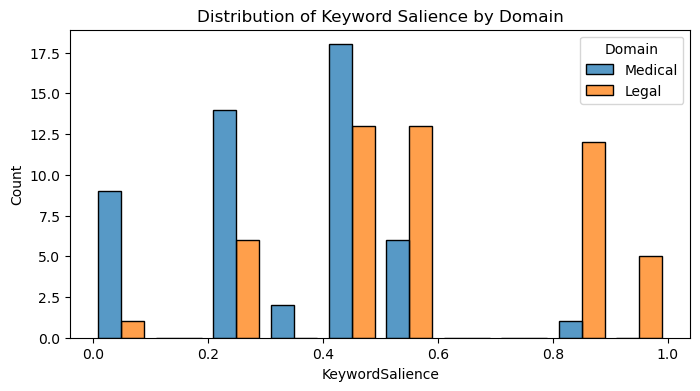

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
sns.histplot(data=qa_pairs, x="KeywordSalience", hue="Domain", bins=10, 
             multiple="dodge", shrink=0.8)
plt.title("Distribution of Keyword Salience by Domain")
plt.show()


## **Unified DataFrame**

- Unified dataframe keep common columns like Question,Answer,Domain,keyword etc.
- create Options column and move domain specific information
- Creates following structure
```
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Domain           100 non-null    object 
 1   question         100 non-null    object 
 2   options          100 non-null    object 
 3   answer           100 non-null    object 
 4   clean_question   100 non-null    object 
 5   tokens           100 non-null    object 
 6   sub2word_map     100 non-null    object 
 7   auto_tags        100 non-null    object 
 8   TagSalience      100 non-null    float64
 9   keywords         100 non-null    object 
 10  KeywordSalience  100 non-null    float64
 ```

- This dataframe will be the input for all analysis

In [15]:
import numpy as np

# 1) Start from your merged QA table
qa = qa_pairs.copy()

# 2) Create a unified `answer` column:
#    - for medical examples, the gold answer lives in `cop`
#    - for legal examples, I think you put it into `exp` earlier?
#      If your merged table already has those moved into `answer` then skip this step.
#
#    Here’s one way to do it if medical answers are in 'cop' and legal are in 'exp':

qa["answer"] = np.where(
    qa["Domain"] == "Medical",
    qa["cop"].astype(str),
    qa["exp"].astype(str)
)

# 3) Pack the four multiple-choice columns into a single list on Medical
#    and give Legal an empty list
def make_options(row):
    if row["Domain"] == "Medical":
        return [row["opa"], row["opb"], row["opc"], row["opd"]]
    else:
        return []

qa["options"] = qa.apply(make_options, axis=1)

# 4) Now drop all of the “raw” per-column fields you no longer need
qa = qa.drop(columns=[
    "opa", "opb", "opc", "opd",
    "cop", "exp",
    # plus any other med-only / legal-only columns, e.g. 'topic_name','subject_name'
])

# 5) Reorder so that your schema is clear:
qa = qa[[
    "Domain", "question", "options", "answer",
    "clean_question", "tokens", "sub2word_map", "auto_tags",
    "TagSalience", "keywords", "KeywordSalience"
]]

# 6) Quick sanity check:
print(qa.info())
display(qa.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Domain           100 non-null    object 
 1   question         100 non-null    object 
 2   options          100 non-null    object 
 3   answer           100 non-null    object 
 4   clean_question   100 non-null    object 
 5   tokens           100 non-null    object 
 6   sub2word_map     100 non-null    object 
 7   auto_tags        100 non-null    object 
 8   TagSalience      100 non-null    float64
 9   keywords         100 non-null    object 
 10  KeywordSalience  100 non-null    float64
dtypes: float64(2), object(9)
memory usage: 8.7+ KB
None


,Domain,question,options,answer,clean_question,tokens,sub2word_map,auto_tags,TagSalience,keywords,KeywordSalience
0,Medical,OPV can be used if vaccine l monitor is showing?,"[Colour of outer circle is same as inner square, Colour of outer circle is darker than inner square, Colour of outer circle is lighter than inner square, None of the above]",1.0,opv can be used if vaccine l monitor is showing?,"[o, p, v, can, be, used, if, vaccine, l, monitor, is, showing, ?]","[opv, opv, opv, can, be, used, if, vaccine, l, monitor, is, showing?, showing?]","[vaccine, symptom, evidence]",0.333333,"[monitor, monitor showing, opv, opv used, used vaccine]",0.2
1,Medical,Average gain of height in first year ?,"[25 cms, 50 cms, 75 cms, 100 cms]",0.0,average gain of height in first year ?,"[average, gain, of, height, in, first, year, ?]","[average, gain, of, height, in, first, year, ?]","[evidence, symptom, procedure]",0.000000,"[average, average gain, gain height, height, height year]",0.4
2,Medical,Investigation of choice to diagnose congenital malformations,"[USG, HSG, MRI, CT]",2.0,investigation of choice to diagnose congenital malformations,"[investigation, of, choice, to, diagnose, con, gen, ital, mal, formation, s]","[investigation, of, choice, to, diagnose, congenital, congenital, congenital, malformations, malformations, malformations]","[procedure, evidence, pathology]",0.000000,"[choice diagnose, congenital, congenital malformations, diagnose, diagnose congenital]",0.2
3,Medical,Pain is appreciated when the small bowel is,"[Burned, crushed, Cut, distended]",3.0,pain is appreciated when the small bowel is,"[pain, is, appreciated, when, the, small, bowel, is]","[pain, is, appreciated, when, the, small, bowel, is]","[symptom, side effects, rights]",0.000000,"[appreciated small, bowel, pain appreciated, small bowel, pain]",0.4
4,Medical,The main advantage of RPD over FPD in replacing bilateral lost teeth is,"[Cross arch stabilization, Aesthetics, Less expensive, Comfort to the patient]",0.0,the main advantage of rpd over fpd in replacing bilateral lost teeth is,"[the, main, advantage, of, r, p, d, over, f, p, d, in, replacing, bilateral, lost, teeth, is]","[the, main, advantage, of, rpd, rpd, rpd, over, fpd, fpd, fpd, in, replacing, bilateral, lost, teeth, is]","[evidence, procedure, treatment]",0.000000,"[advantage, advantage rpd, bilateral, bilateral lost, fpd]",0.4
